In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

# Load the dataset

In [2]:
offers = pd.read_csv("raw_data\offers.csv")
offers.sort_values(by="offer_type")

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"['web', 'email', 'mobile']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']"


In [3]:
events = pd.read_csv("raw_data\events.csv")
events.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
customers = pd.read_csv("raw_data\customers.csv")
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,118,NaN


In [5]:
customers["became_member_on"] = customers["became_member_on"].astype(str)
customers["became_member_on"] = pd.to_datetime(
    customers["became_member_on"], format="%Y%m%d"
)
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


## Table with customers with missing information

In [7]:
# dataframe of the the blank gender and income and 118 years old. These are removed because of missing values
df_empty = customers[
    (customers["gender"].isna())
    & (customers["income"].isna())
    & (customers["age"] == 118)
]

df_empty.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,118,NaN
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,118,NaN


In [26]:
df_empty.shape

(2175, 5)

# Analysing Events

## Events of customers with missing details

In [8]:
events_empty = events[events["customer_id"].isin(df_empty["customer_id"].values)]
events_empty.head()

,customer_id,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


## Tables with each event

In [11]:
events_empty.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [12]:
# Event Types dataframes
transactions = events_empty[events_empty["event"] == "transaction"].copy()
offers_received = events_empty[events_empty["event"] == "offer received"].copy()
offers_viewed = events_empty[events_empty["event"] == "offer viewed"].copy()
offers_completed = events_empty[events_empty["event"] == "offer completed"].copy()

In [31]:
print(f"DataFrame Sizes: \nOriginal: {events_empty.shape}\nTransactions: {transactions.shape}\nOffers Received: {offers_received.shape}\nOffers Viewed: {offers_viewed.shape}\nOffers Completed : {offers_completed.shape}")

DataFrame Sizes: 
Original: (33772, 4)
Transactions: (14996, 4)
Offers Received: (9776, 4)
Offers Viewed: (7865, 4)
Offers Completed : (1135, 4)


## Explore Transactions

In [13]:
transactions.head()

,customer_id,event,value,time
12686,bbeb54e861614fc7b22a8844f72dca6c,transaction,{'amount': 0.22},0
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,{'amount': 1.02},0
12777,ed46fca6de7042478b411690878dc069,transaction,{'amount': 1.16},0
12849,098d124614df4e4b862d678160b98638,transaction,{'amount': 1.21},0
12854,62bacb593a434f0d96b814075418e983,transaction,{'amount': 2.95},0


In [14]:
# unpack value column
amounts = []
for amount in transactions["value"].values:
    amount = ast.literal_eval(amount)
    amounts.append(amount["amount"])

amounts[:10]

[0.22, 1.02, 1.16, 1.21, 2.95, 5.31, 3.26, 1.33, 0.23, 1.0]

In [15]:
transactions["money_spent"] = amounts
transactions = transactions.drop(["value"], axis=1)
transactions.head()

,customer_id,event,time,money_spent
12686,bbeb54e861614fc7b22a8844f72dca6c,transaction,0,0.22
12738,7ca349e55ff544c7a13addfdea2e2c06,transaction,0,1.02
12777,ed46fca6de7042478b411690878dc069,transaction,0,1.16
12849,098d124614df4e4b862d678160b98638,transaction,0,1.21
12854,62bacb593a434f0d96b814075418e983,transaction,0,2.95


In [19]:
transactions.isna().sum()

customer_id    0
event          0
time           0
money_spent    0
dtype: int64

Text(0.5, 0, 'Hours passed in the 30-day period (starting at 0)')

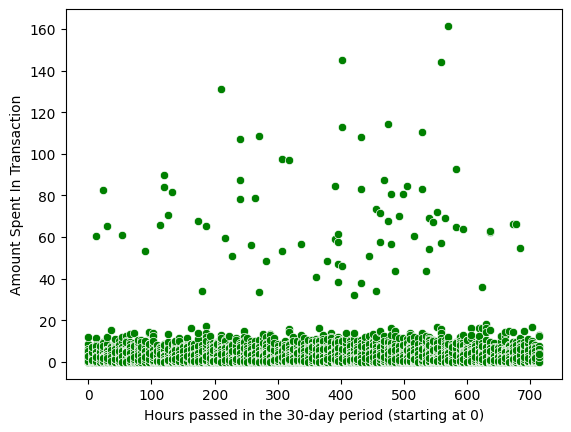

In [16]:
sns.scatterplot(data=transactions, x="time", y="money_spent", color="green")
plt.ylabel("Amount Spent In Transaction")
plt.xlabel("Hours passed in the 30-day period (starting at 0)")

* As the number of hours increases (from start to the end of the trial or campaign), most customers spend less amount of money

In [17]:
# Maximum hours in the month. Therefore the closer to this time, the latter the transation or offer event
max_hours = 30 * 24

In [18]:
# Transaction per customer
transactions_per_customer = (
    transactions.groupby("customer_id")
    .agg({
            "money_spent": lambda x: x.sum(),
            "event": lambda x: x.count(),
            "time": lambda x: max_hours - x.max(),
        })
    .reset_index()
)

transactions_per_customer.rename(
    columns={"money_spent": "money", "event": "frequency", "time": "recency"},
    inplace=True,
)

transactions_per_customer.head()

,customer_id,money,frequency,recency
0,00116118485d4dfda04fdbaba9a87b5c,4.09,3,246
1,0063def0f9c14bc4805322a488839b32,7.21,3,330
2,0069a50874d846438e58acff5e594725,33.50,5,24
3,0092a132ead946ceb30d11a1ed513d20,2.54,3,168
4,009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36


## Explore Offers Received

In [20]:
offers_received.head()

,customer_id,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [21]:
# unpack value column
offer_ids = []
for offer_id in offers_received["value"].values:
    offer_id = ast.literal_eval(offer_id)
    offer_ids.append(offer_id["offer id"])

offer_ids[:10]

['0b1e1539f2cc45b7b9fa7c272da2e1d7',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '2906b810c7d4411798c6938adc9daaa5',
 '2906b810c7d4411798c6938adc9daaa5',
 '2906b810c7d4411798c6938adc9daaa5',
 'fafdcd668e3743c1bb461111dcafc2a4']

In [22]:
offers_received["offer_received"] = offer_ids
offers_received = offers_received.drop(["value"], axis=1)
offers_received.head()

,customer_id,event,time,offer_received
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [23]:
# offers per customer
n_offers_per_customer = (
    offers_received.groupby("customer_id")
    .agg({"time": lambda x: max_hours - x.max(), "offer_received": lambda x: x.count()})
    .reset_index()
)

n_offers_per_customer.rename(columns={"time": "time_for_latest_offer"}, inplace=True)

n_offers_per_customer.head()

,customer_id,time_for_latest_offer,offer_received
0,00116118485d4dfda04fdbaba9a87b5c,144,2
1,0063def0f9c14bc4805322a488839b32,144,5
2,0069a50874d846438e58acff5e594725,144,4
3,0092a132ead946ceb30d11a1ed513d20,144,6
4,009d10c2c38a4fd795a7bc6ddbbddb78,144,5


In [24]:
n_offers_per_customer.isna().sum()

customer_id              0
time_for_latest_offer    0
offer_received           0
dtype: int64

Text(0.5, 0, 'Last time offers received')

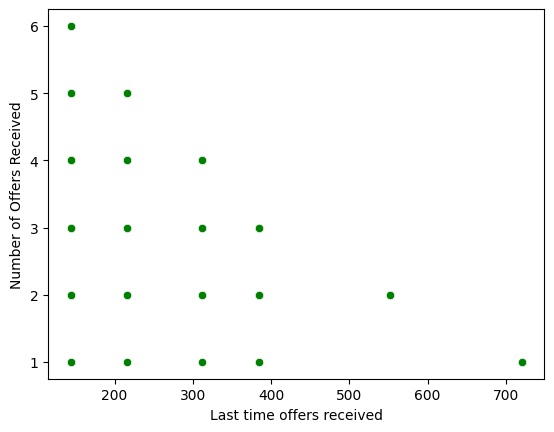

In [25]:
sns.scatterplot(
    data=n_offers_per_customer,
    x="time_for_latest_offer",
    y="offer_received",
    color="green",
)
plt.ylabel("Number of Offers Received")
plt.xlabel("Last time offers received")

* Most offers were received in the closer to the end date for trials

**Did everyone receive an offer?**

In [32]:
customers_transactions = transactions_per_customer["customer_id"].unique()
customers_offers_received = n_offers_per_customer["customer_id"].unique()

In [33]:
len(customers_transactions) == len(customers_offers_received)

False

In [34]:
len(customers_transactions), len(customers_offers_received)

(2086, 2174)

In [35]:
customers_with_no_offers = []

for customer in customers_offers_received:
    if customer not in customers_transactions:
        customers_with_no_offers.append(customer)

len(customers_with_no_offers)

89

* 89 customers received an offer but have no history of transactions

### Customers Transactions vs Offers Received

In [36]:
# number of offers a customer received and the money spent (RFM)
df_00 = n_offers_per_customer.set_index("customer_id").join(
    transactions_per_customer.set_index("customer_id")
)
df_00.head()

,time_for_latest_offer,offer_received,money,frequency,recency
customer_id,,,,,
00116118485d4dfda04fdbaba9a87b5c,144,2,4.09,3.0,246.0
0063def0f9c14bc4805322a488839b32,144,5,7.21,3.0,330.0
0069a50874d846438e58acff5e594725,144,4,33.50,5.0,24.0
0092a132ead946ceb30d11a1ed513d20,144,6,2.54,3.0,168.0
009d10c2c38a4fd795a7bc6ddbbddb78,144,5,11.78,7.0,36.0


In [37]:
df_00.isna().sum()

time_for_latest_offer     0
offer_received            0
money                    89
frequency                89
recency                  89
dtype: int64

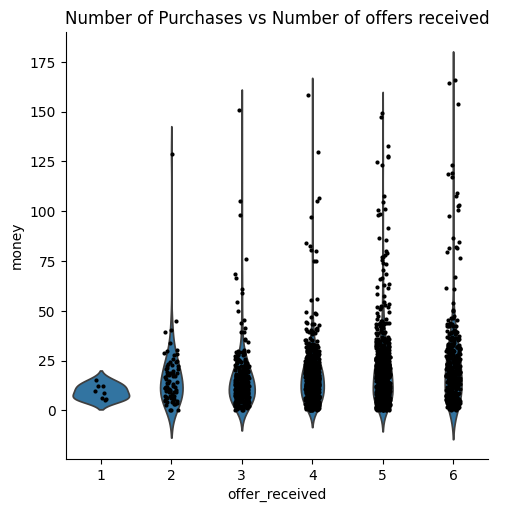

In [38]:
g = sns.catplot(data=df_00, x="offer_received", y="money", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="money", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

* The more money a customer spent, the more the number of offers received

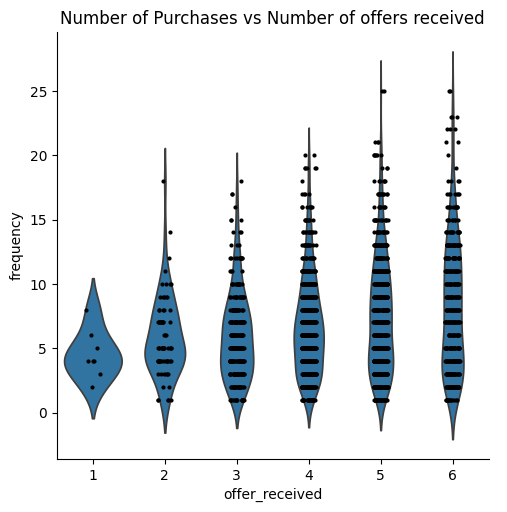

In [39]:
g = sns.catplot(data=df_00, x="offer_received", y="frequency", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="frequency", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

* The higher the number of purchases, the more the number of offers received

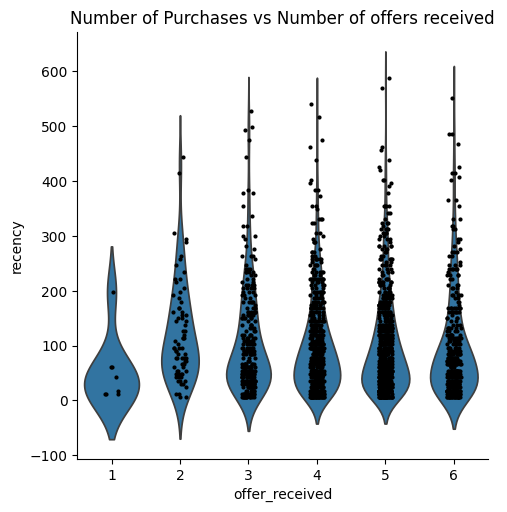

In [40]:
g = sns.catplot(data=df_00, x="offer_received", y="recency", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="recency", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

* Those who bought more recently, received fewer offers

## Explore offers Viewed

In [41]:
offers_viewed.head()

,customer_id,event,value,time
12663,53bac762af27471eb294ff89ca1bae2c,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
12664,182e68952b474700b171e21b85c258ac,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12668,c099206f76b1414db7552f163520053c,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
12676,50b92ea51e2649dfbf7120d5e554e991,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12680,41f9e7e0d8c644bb8b3f9c3a8699dc53,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0


In [42]:
offers_viewed_ids = []

for offer in offers_viewed["value"].values:
    offer = ast.literal_eval(offer)
    offers_viewed_ids.append(offer["offer id"])

offers_viewed_ids[:10]

['fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '5a8bc65990b245e5a138643cd4eb9837',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '3f207df678b143eea3cee63160fa8bed']

In [43]:
offers_viewed["offer_id"] = offers_viewed_ids
offers_viewed = offers_viewed.drop(["value"], axis=1)
offers_viewed.head()

,customer_id,event,time,offer_id
12663,53bac762af27471eb294ff89ca1bae2c,offer viewed,0,fafdcd668e3743c1bb461111dcafc2a4
12664,182e68952b474700b171e21b85c258ac,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d
12668,c099206f76b1414db7552f163520053c,offer viewed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12676,50b92ea51e2649dfbf7120d5e554e991,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837
12680,41f9e7e0d8c644bb8b3f9c3a8699dc53,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd


In [44]:
offers_viewed_per_customer = (
    offers_viewed.groupby(["customer_id"])
    .agg({"time": lambda x: max_hours - x.max(), "offer_id": lambda x: x.count()})
    .reset_index()
)

offers_viewed_per_customer.rename(
    columns={"time": "time_last_offer_viewed", "offer_id": "offers_viewed"},
    inplace=True,
)

offers_viewed_per_customer.head()

,customer_id,time_last_offer_viewed,offers_viewed
0,00116118485d4dfda04fdbaba9a87b5c,90,2
1,0063def0f9c14bc4805322a488839b32,144,5
2,0069a50874d846438e58acff5e594725,168,1
3,0092a132ead946ceb30d11a1ed513d20,138,6
4,009d10c2c38a4fd795a7bc6ddbbddb78,144,5


**Did everyone receive an offer?**

In [45]:
customers_offers_viewed = offers_viewed_per_customer["customer_id"].unique()
customers_offers_received = n_offers_per_customer["customer_id"].unique()

In [46]:
len(customers_offers_received) == len(customers_offers_viewed)

False

In [48]:
len(customers_offers_received), len(customers_offers_viewed)

(2174, 2159)

In [47]:
customers_without_offer_viewed = []

for customer in customers_offers_received:
    if customer not in customers_offers_viewed:
        customers_without_offer_viewed.append(customer)

len(customers_without_offer_viewed)

15

* 15 customers did not view their offers after receiving them

## Explore Offers Completed

In [49]:
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


In [50]:
rewards = []
completed_offers_ids = []

for offer in offers_completed["value"].values:
    offer = ast.literal_eval(offer)
    rewards.append(offer["reward"])
    completed_offers_ids.append(offer["offer_id"])

In [51]:
offers_completed["rewards"] = rewards
offers_completed["offer_id"] = completed_offers_ids
offers_completed.drop(["value"], axis=1, inplace=True)
offers_completed.head()

,customer_id,event,time,rewards,offer_id
13838,3bfb10e9ca4f4e6292425d16c0c1cff3,offer completed,0,5,f19421c1d4aa40978ebb69ca19b0e20d
14848,3afdcadc6c364dbd93a68d29b6abbcb8,offer completed,0,5,f19421c1d4aa40978ebb69ca19b0e20d
15885,e5fec103d6ab473998b14851f448cbf5,offer completed,6,5,f19421c1d4aa40978ebb69ca19b0e20d
16399,d09c99f76c7d4fbf9fc7ae5c833f3e38,offer completed,6,5,f19421c1d4aa40978ebb69ca19b0e20d
17890,5bba4b591ff5402b912deb5b7c6c4b4c,offer completed,6,5,f19421c1d4aa40978ebb69ca19b0e20d


In [52]:
n_offers_completed_per_customer = (offers_completed.groupby("customer_id")
    .agg({
            "offer_id": lambda x: x.count(),
            "rewards": lambda x: x.sum(),
            "time": lambda x: max_hours - x.max(),
        })
    .reset_index()
)

n_offers_completed_per_customer.rename(
    columns={"offer_id": "offers_completed", "time": "time_last_offer_completed"}, inplace=True,)

n_offers_completed_per_customer.head()

,customer_id,offers_completed,rewards,time_last_offer_completed
0,0069a50874d846438e58acff5e594725,1,2,24
1,0106d19a26af41288035afc4b9b6c2c2,1,5,48
2,01e91c5bc14148b2a4de0ce819e4c500,1,5,294
3,020354b1aea342cbaa018993f68fba68,1,3,54
4,027561a162a54d86b6d45af5071c4d27,1,5,246


# Merge all the per customer tables

* transactions
* offers viewed
* offers received
* offers completed

**Copies of Tables**

In [62]:
df_t = transactions_per_customer.copy()  # transactions
df_or = n_offers_per_customer.copy()  # offers received
df_ov = offers_viewed_per_customer.copy()  # offers viewed
df_oc = n_offers_completed_per_customer.copy()  # offers completed

In [63]:
rfm_ext = (
    df_t.set_index("customer_id")
    .join(df_or.set_index("customer_id"))
    .join(df_ov.set_index("customer_id"))
    .join(df_oc.set_index("customer_id"))
)
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed
customer_id,,,,,,,,,,
00116118485d4dfda04fdbaba9a87b5c,4.09,3,246,144.0,2.0,90.0,2.0,NaN,NaN,NaN
0063def0f9c14bc4805322a488839b32,7.21,3,330,144.0,5.0,144.0,5.0,NaN,NaN,NaN
0069a50874d846438e58acff5e594725,33.50,5,24,144.0,4.0,168.0,1.0,1.0,2.0,24.0
0092a132ead946ceb30d11a1ed513d20,2.54,3,168,144.0,6.0,138.0,6.0,NaN,NaN,NaN
009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36,144.0,5.0,144.0,5.0,NaN,NaN,NaN


In [64]:
rfm_ext.isna().sum()

money                           0
frequency                       0
recency                         0
time_for_latest_offer           1
offer_received                  1
time_last_offer_viewed         16
offers_viewed                  16
offers_completed             1298
rewards                      1298
time_last_offer_completed    1298
dtype: int64

In [65]:
rfm_ext = rfm_ext.fillna(0)
rfm_ext.isna().sum()

money                        0
frequency                    0
recency                      0
time_for_latest_offer        0
offer_received               0
time_last_offer_viewed       0
offers_viewed                0
offers_completed             0
rewards                      0
time_last_offer_completed    0
dtype: int64

**Add Customer Details**

In [66]:
rfm_ext = rfm_ext.join(customers.set_index("customer_id"))
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,became_member_on,gender,age,income
customer_id,,,,,,,,,,,,,,
00116118485d4dfda04fdbaba9a87b5c,4.09,3,246,144.0,2.0,90.0,2.0,0.0,0.0,0.0,2018-04-25,NaN,118,NaN
0063def0f9c14bc4805322a488839b32,7.21,3,330,144.0,5.0,144.0,5.0,0.0,0.0,0.0,2018-06-15,NaN,118,NaN
0069a50874d846438e58acff5e594725,33.50,5,24,144.0,4.0,168.0,1.0,1.0,2.0,24.0,2016-05-03,NaN,118,NaN
0092a132ead946ceb30d11a1ed513d20,2.54,3,168,144.0,6.0,138.0,6.0,0.0,0.0,0.0,2018-05-02,NaN,118,NaN
009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36,144.0,5.0,144.0,5.0,0.0,0.0,0.0,2018-06-27,NaN,118,NaN


In [67]:
rfm_ext = rfm_ext.drop(["gender", "income", "age"], axis = 1)

**Change the day of joining to number of days before the Trial starts**

Assuming trial start date of 01 August 2018

In [69]:
# Assume that the project ran between 01 and 30 August 2018. Therefore find how many days a customer join before the begining of the trial
last_joining_date = pd.to_datetime("2018-08-01")
last_joining_date

Timestamp('2018-08-01 00:00:00')

In [70]:
rfm_ext["joined_days"] = rfm_ext["became_member_on"].apply(
    lambda x: last_joining_date - x
)
rfm_ext["joined_days"] = rfm_ext["joined_days"].dt.days
rfm_ext.drop(["became_member_on"], axis=1, inplace=True)
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days
customer_id,,,,,,,,,,,
00116118485d4dfda04fdbaba9a87b5c,4.09,3,246,144.0,2.0,90.0,2.0,0.0,0.0,0.0,98
0063def0f9c14bc4805322a488839b32,7.21,3,330,144.0,5.0,144.0,5.0,0.0,0.0,0.0,47
0069a50874d846438e58acff5e594725,33.50,5,24,144.0,4.0,168.0,1.0,1.0,2.0,24.0,820
0092a132ead946ceb30d11a1ed513d20,2.54,3,168,144.0,6.0,138.0,6.0,0.0,0.0,0.0,91
009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36,144.0,5.0,144.0,5.0,0.0,0.0,0.0,35


In [71]:
rfm_ext.isna().sum()

money                        0
frequency                    0
recency                      0
time_for_latest_offer        0
offer_received               0
time_last_offer_viewed       0
offers_viewed                0
offers_completed             0
rewards                      0
time_last_offer_completed    0
joined_days                  0
dtype: int64

In [72]:
rfm_ext.shape

(2086, 11)

# Data Preparation

## Scale Data

In [84]:
X = rfm_ext.copy()

In [85]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled

array([[-0.80554416, -0.977567  ,  1.60245086, ..., -0.58219593,
        -0.58127   , -1.14606654],
       [-0.64159497, -0.977567  ,  2.5288866 , ..., -0.58219593,
        -0.58127   , -1.2913416 ],
       [ 0.7398871 , -0.51082295, -0.84598645, ...,  0.00520949,
        -0.43449247,  0.91057254],
       ...,
       [ 0.62585834,  1.82289731, -0.38276858, ...,  0.00520949,
         0.29939521,  0.30098699],
       [-0.496563  , -0.977567  ,  0.21279725, ..., -0.58219593,
        -0.58127   , -0.63333104],
       [ 0.10143114,  0.88940921, -0.58129052, ..., -0.58219593,
        -0.58127   , -1.34546368]])

## Clustering

**PCA**

In [86]:
# 2D scatter plot (if you reduce dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

**Elbow Method and Silhoutte Score**

In [87]:
# Range of k values to try
k_values = range(1, 20)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    labels = kmeans.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

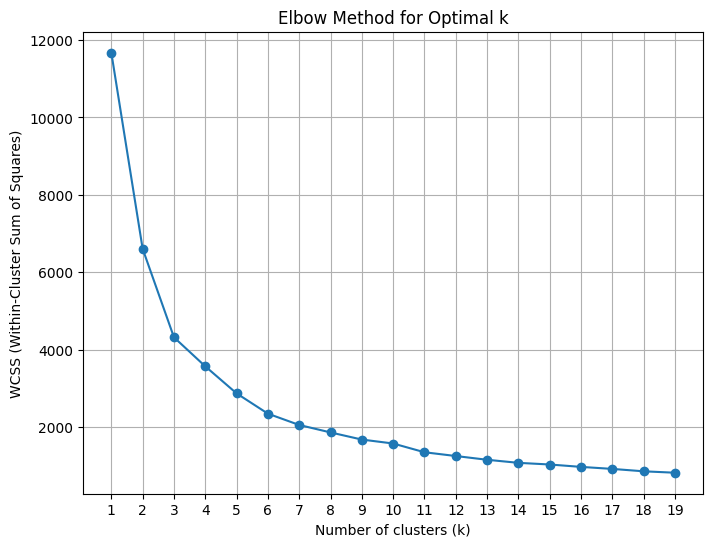

In [88]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks([x for x in k_values])
plt.grid(True)
plt.show()

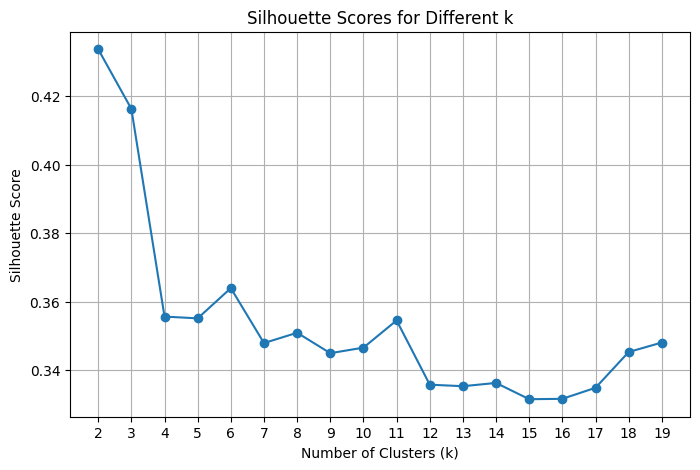

In [89]:
# Plot silhouette scores
k_range = range(2, 20)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks([x for x in k_range])
plt.grid(True)
plt.show()

* According to the above elbow method and silhouette score, a k = 2 is the best number of clusters

**Fit KMeans Model**

In [102]:
model = KMeans(n_clusters=2, random_state=0)
model.fit(X_pca)

KMeans(n_clusters=2, random_state=0)

In [103]:
clusters = model.labels_

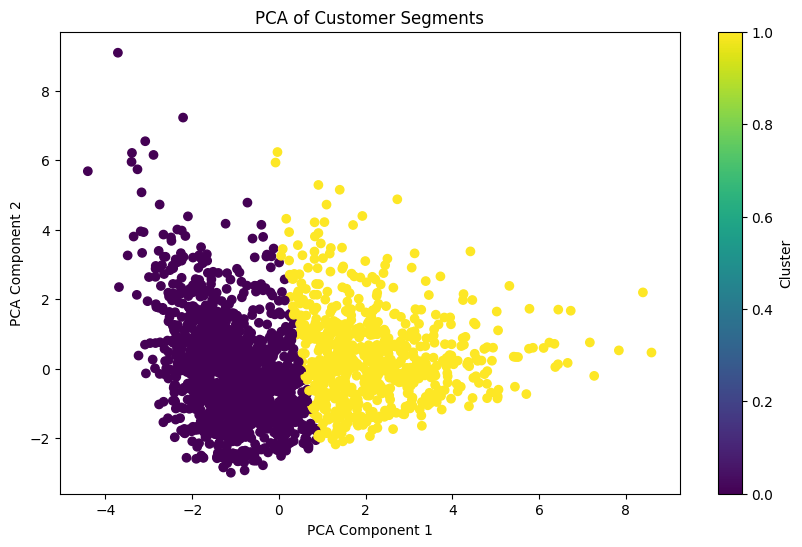

In [104]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.colorbar(scatter, label="Cluster")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Customer Segments")
plt.show()

* 2 clusters looks better and this clusters look separate from each other

## Snake Plot

In [105]:
X.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days
customer_id,,,,,,,,,,,
00116118485d4dfda04fdbaba9a87b5c,4.09,3,246,144.0,2.0,90.0,2.0,0.0,0.0,0.0,98
0063def0f9c14bc4805322a488839b32,7.21,3,330,144.0,5.0,144.0,5.0,0.0,0.0,0.0,47
0069a50874d846438e58acff5e594725,33.50,5,24,144.0,4.0,168.0,1.0,1.0,2.0,24.0,820
0092a132ead946ceb30d11a1ed513d20,2.54,3,168,144.0,6.0,138.0,6.0,0.0,0.0,0.0,91
009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36,144.0,5.0,144.0,5.0,0.0,0.0,0.0,35


In [106]:
X_clusters = pd.DataFrame(X_scaled, columns=X.columns)
X_clusters["Cluster"] = clusters
X_clusters.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days,Cluster
0,-0.805544,-0.977567,1.602451,-0.482433,-2.303159,-0.789399,-1.213220,-0.660064,-0.582196,-0.581270,-1.146067,0
1,-0.641595,-0.977567,2.528887,-0.482433,0.466474,-0.264512,1.061977,-0.660064,-0.582196,-0.581270,-1.291342,0
2,0.739887,-0.510823,-0.845986,-0.482433,-0.456737,-0.031229,-1.971619,0.553058,0.005209,-0.434492,0.910573,0
3,-0.886993,-0.977567,0.742189,-0.482433,1.389685,-0.322833,1.820376,-0.660064,-0.582196,-0.581270,-1.166006,0
4,-0.401451,-0.044079,-0.713638,-0.482433,0.466474,-0.264512,1.061977,-0.660064,-0.582196,-0.581270,-1.325524,0


In [107]:
cols_to_plot = ["money","frequency","recency"]

In [108]:
X_melted = pd.melt(
    X_clusters.reset_index(),
    id_vars=["Cluster"],
    value_vars=cols_to_plot,
    var_name="Attribute",
    value_name="Value",
)

X_melted.head()

,Cluster,Attribute,Value
0,0,money,-0.805544
1,0,money,-0.641595
2,0,money,0.739887
3,0,money,-0.886993
4,0,money,-0.401451


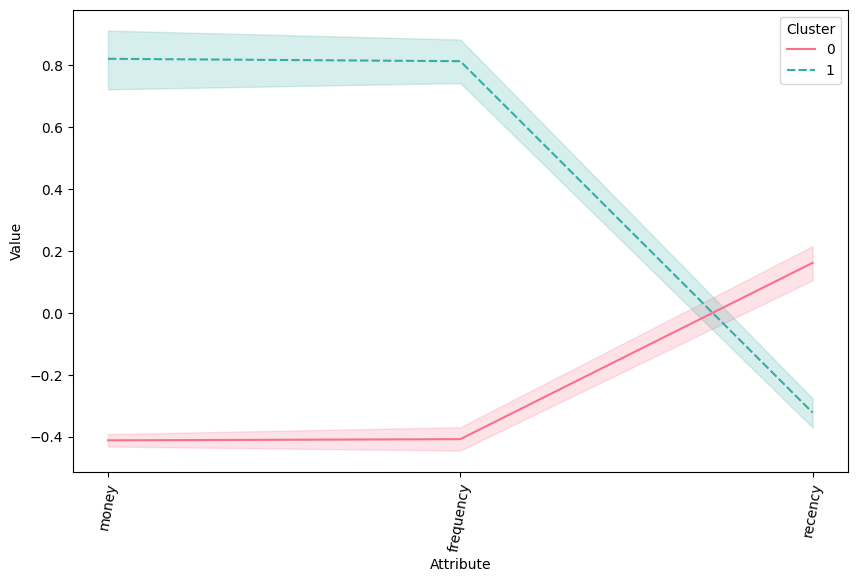

In [109]:
palette = sns.color_palette("husl", n_colors=X_melted["Cluster"].nunique())

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=X_melted,
    x="Attribute",
    y="Value",
    style="Cluster",
    palette=palette,
    hue="Cluster",
)
plt.xticks(rotation=80)
plt.show()

* Cluster 0: Customers who spent smallest amount of money and don't buy frequently and last bought some time ago (Lost Customers)
* Cluster 1: Customers who spent large amount of money and are very frequent in their purchases and last bought recently (Loyal Customers)

# EDA for each cluster

In [110]:
# Copy of rfm extended
df = rfm_ext.copy()

In [111]:
# adding clusters to the original data
df["cluster"] = clusters
df.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days,cluster
customer_id,,,,,,,,,,,,
00116118485d4dfda04fdbaba9a87b5c,4.09,3,246,144.0,2.0,90.0,2.0,0.0,0.0,0.0,98,0
0063def0f9c14bc4805322a488839b32,7.21,3,330,144.0,5.0,144.0,5.0,0.0,0.0,0.0,47,0
0069a50874d846438e58acff5e594725,33.50,5,24,144.0,4.0,168.0,1.0,1.0,2.0,24.0,820,0
0092a132ead946ceb30d11a1ed513d20,2.54,3,168,144.0,6.0,138.0,6.0,0.0,0.0,0.0,91,0
009d10c2c38a4fd795a7bc6ddbbddb78,11.78,7,36,144.0,5.0,144.0,5.0,0.0,0.0,0.0,35,0


## Clusters Summary Stats

In [112]:
df["cluster"].value_counts()

cluster
0    1389
1     697
Name: count, dtype: int64

In [113]:
df["cluster"].value_counts(normalize=True)

cluster
0    0.665868
1    0.334132
Name: proportion, dtype: float64

* 67% customers are in cluster 0 and 33% in cluster 1

In [115]:
df_c1 = df[df["cluster"] == 0]
df_c2 = df[df["cluster"] == 1]

In [116]:
df_c1.describe()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days,cluster
count,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.000000,1389.0
mean,11.575709,5.439165,115.369330,175.343413,4.331174,173.136069,3.469402,0.084953,0.295176,13.088553,432.490281,0.0
std,7.730381,3.134602,100.017778,61.563357,1.105938,104.641736,1.325854,0.284032,1.058443,53.227004,346.839806,0.0
min,0.050000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.0
25%,5.710000,3.000000,42.000000,144.000000,4.000000,120.000000,3.000000,0.000000,0.000000,0.000000,179.000000,0.0
50%,10.420000,5.000000,84.000000,144.000000,4.000000,144.000000,3.000000,0.000000,0.000000,0.000000,318.000000,0.0
75%,16.400000,7.000000,162.000000,216.000000,5.000000,210.000000,4.000000,0.000000,0.000000,0.000000,657.000000,0.0
max,68.680000,18.000000,588.000000,720.000000,6.000000,720.000000,6.000000,2.000000,10.000000,594.000000,1817.000000,0.0


In [117]:
df_c2.describe()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,joined_days,cluster
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.0
mean,35.051521,10.675753,71.483501,163.144907,4.820660,167.380201,3.859397,1.459110,5.344333,258.370158,635.540890,1.0
std,24.469258,4.141311,58.358066,43.784516,0.957864,99.313131,1.266399,0.785176,3.938347,185.376088,319.334026,0.0
min,8.380000,1.000000,6.000000,144.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,1.0
25%,21.580000,8.000000,30.000000,144.000000,4.000000,120.000000,3.000000,1.000000,2.000000,120.000000,364.000000,1.0
50%,28.390000,10.000000,60.000000,144.000000,5.000000,138.000000,4.000000,1.000000,5.000000,216.000000,629.000000,1.0
75%,36.280000,13.000000,96.000000,144.000000,6.000000,198.000000,5.000000,2.000000,7.000000,366.000000,887.000000,1.0
max,165.680000,25.000000,366.000000,552.000000,6.000000,720.000000,6.000000,5.000000,27.000000,720.000000,1825.000000,1.0


## Distribution in each cluster

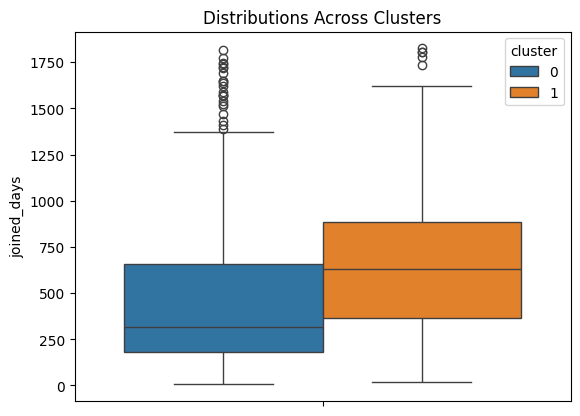

In [119]:
sns.boxplot(data=df, y="joined_days", hue="cluster")
plt.title("Distributions Across Clusters")
plt.show()

* Customers in cluster 0 joined towards the beginning of the campaign while customers in cluster 0 joined a bit earlier

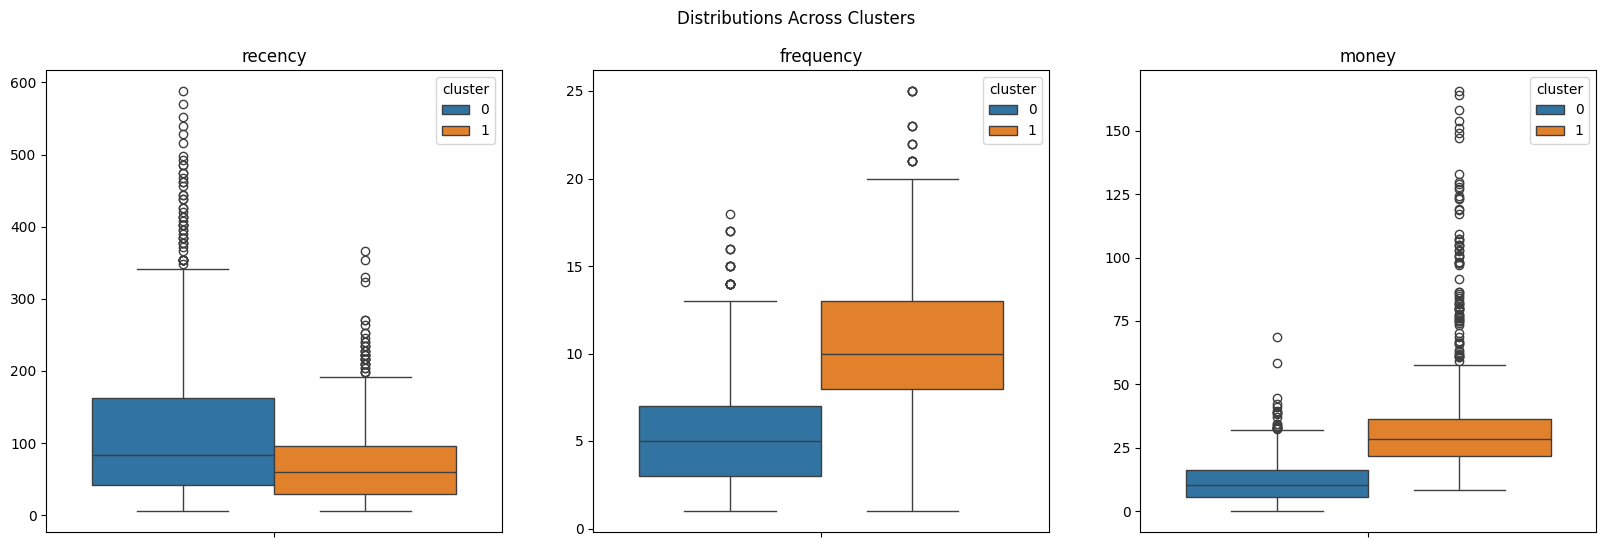

In [120]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="recency", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="frequency", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="money", hue="cluster", ax=axs[2])

col_name = [
    "recency",
    "frequency",
    "money",
]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Cluster 0 customers last bought some time ago compared to those in cluster 1
* Cluster 0 customers bought less frequently compared to those in cluster 1 who made multiple purchases
* Cluster 0 customers spent less money when making purchases as compared to those in cluster 1 

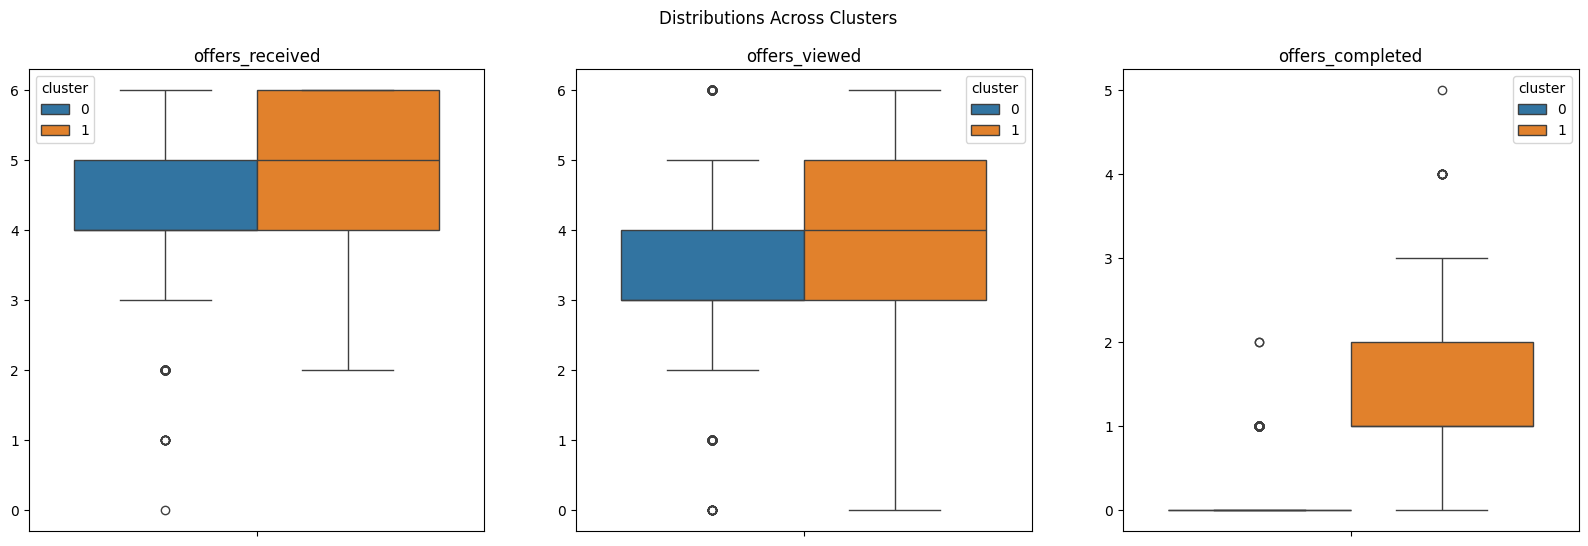

In [121]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="offer_received", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="offers_viewed", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="offers_completed", hue="cluster", ax=axs[2])

col_name = ["offers_received", "offers_viewed", "offers_completed"]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Those in cluster 1 received more offers than those in cluster 0
* Those in cluster 1 viewed most of their offers
* Those in cluster 1 completed most of their offers and those in cluster 0 who completed very little of their offer.

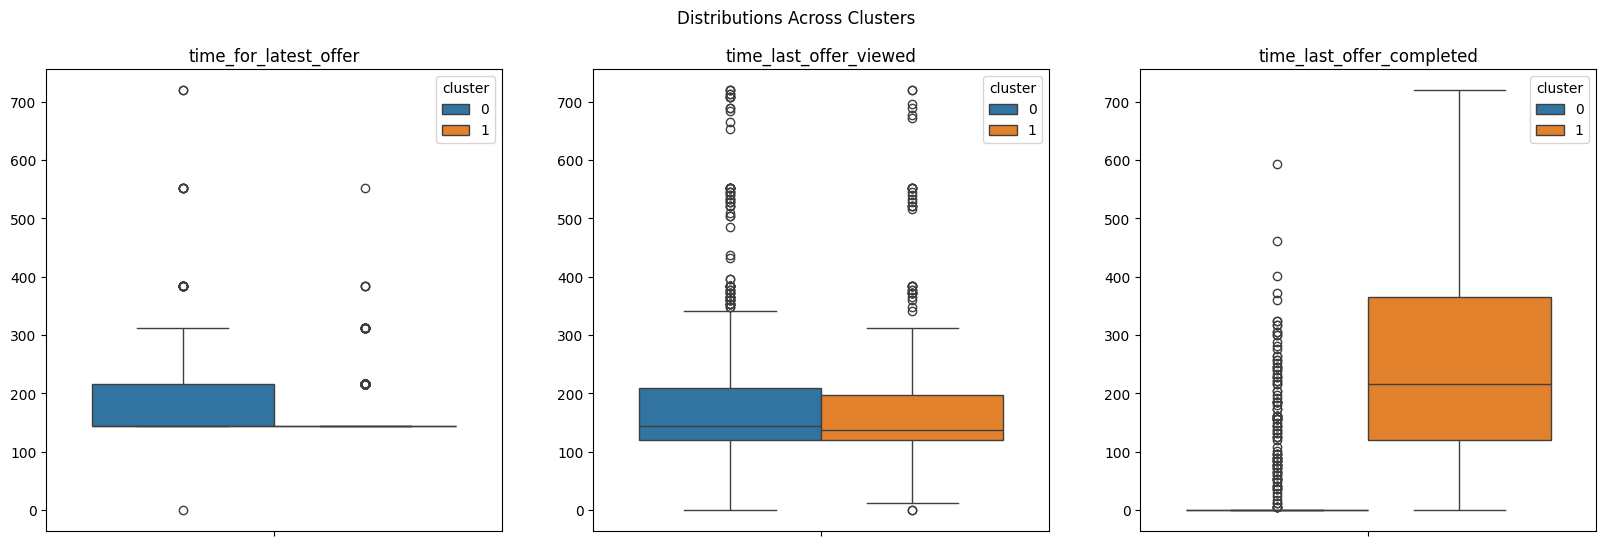

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="time_for_latest_offer", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="time_last_offer_viewed", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="time_last_offer_completed", hue="cluster", ax=axs[2])

col_name = [
    "time_for_latest_offer",
    "time_last_offer_viewed",
    "time_last_offer_completed",
]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Customers in cluster 0 received most of their latest offers early in the campaign while those in cluster 1 received their later on and mostly at the same time
* Most of the customers viewed their offers at the same time
* Those in cluster 0 completed their offers late compared to those in cluster 1

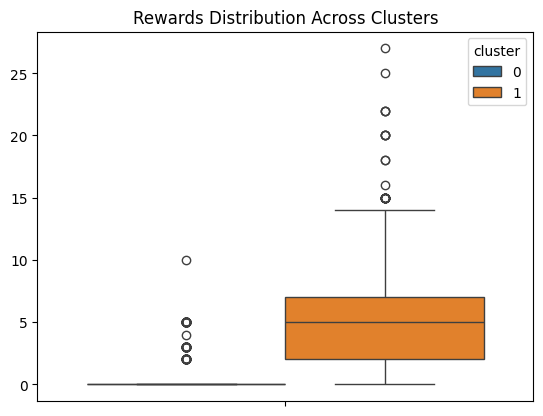

In [123]:
sns.boxplot(data=df, y="rewards", hue="cluster")
plt.title("Rewards Distribution Across Clusters")
plt.ylabel("")
plt.show()

* Customers in cluster 1 received large amount in rewards compared to those in cluster 0 who got very little rewards

**Is there an overlap of customer across clusters?**

In [125]:
customer_c1 = df_c1.index
customer_c2 = df_c2.index

In [126]:
for customer in customer_c1:
    if customer in customer_c2:
        print("Found in cluster 2")

In [127]:
for customer in customer_c2:
    if customer in customer_c1:
        print("Found in cluster 1")

* No customers overlap into other clusters

# Offers Ratio

In [128]:
# function to consolidate the received, viewed and completed ratio


def ratio_calcs(customers_list):
    # offers received
    received = offers_received[offers_received["customer_id"].isin(customers_list)]
    received_agg = (
        received.groupby("offer_received")
        .agg({"event": lambda x: x.count()})
        .reset_index()
    )

    # offers viewed
    viewed = offers_viewed[offers_viewed["customer_id"].isin(customers_list)]
    viewed_agg = (
        viewed.groupby("offer_id").agg({"event": lambda x: x.count()}).reset_index()
    )

    # offers completed
    completed = offers_completed[offers_completed["customer_id"].isin(customers_list)]
    completed_agg = (
        completed.groupby("offer_id").agg({"event": lambda x: x.count()}).reset_index()
    )

    # combine all three tables
    agg = (
        received_agg.set_index("offer_received")
        .join(viewed_agg.set_index("offer_id"), rsuffix="_v")
        .join(completed_agg.set_index("offer_id"), rsuffix="_c")
    )
    agg = agg.reset_index()
    agg.rename(
        columns={
            "offer_received": "offer_id",
            "event": "n_received",
            "event_v": "n_viewed",
            "event_c": "n_completed",
        },
        inplace=True,
    )

    # calculate ratios
    agg["viewed/received"] = 100 * agg["n_viewed"] / agg["n_received"]
    agg["completed/viewed"] = 100 * agg["n_completed"] / agg["n_viewed"]
    agg["completed/received"] = 100 * agg["n_completed"] / agg["n_received"]

    # get offers metadata
    agg_meta = agg.set_index("offer_id").join(offers.set_index("offer_id"))

    # create a readale name using offer_id and offer type
    offer_name = []
    for i, offer_type in enumerate(agg_meta.offer_type.values):
        name = offer_type + "_" + agg_meta.index[i][:3]
        offer_name.append(name)

    agg_meta["offer_name"] = offer_name
    agg_meta = agg_meta.reset_index()

    return agg_meta

In [129]:
offers_c1 = ratio_calcs(customer_c1)
offers_c1

,offer_id,n_received,n_viewed,n_completed,viewed/received,completed/viewed,completed/received,offer_type,difficulty,reward,duration,channels,offer_name
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,600,296,NaN,49.333333,NaN,NaN,discount,20,5,10,"['web', 'email']",discount_0b1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,555,538,37.0,96.936937,6.877323,6.666667,discount,7,3,7,"['web', 'email', 'mobile', 'social']",discount_229
2,2906b810c7d4411798c6938adc9daaa5,634,422,10.0,66.561514,2.369668,1.577287,discount,10,2,7,"['web', 'email', 'mobile']",discount_290
3,3f207df678b143eea3cee63160fa8bed,620,440,NaN,70.967742,NaN,NaN,informational,0,0,4,"['web', 'email', 'mobile']",informational_3f2
4,4d5c57ea9a6940dd891ad53e9dbe8da0,661,634,NaN,95.915280,NaN,NaN,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",bogo_4d5
5,5a8bc65990b245e5a138643cd4eb9837,653,537,NaN,82.235835,NaN,NaN,informational,0,0,3,"['email', 'mobile', 'social']",informational_5a8
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,615,422,28.0,68.617886,6.635071,4.552846,bogo,5,5,7,"['web', 'email', 'mobile']",bogo_9b9
7,ae264e3637204a6fb9bb56bc8210ddfd,614,499,1.0,81.270358,0.200401,0.162866,bogo,10,10,7,"['email', 'mobile', 'social']",bogo_ae2
8,f19421c1d4aa40978ebb69ca19b0e20d,580,562,15.0,96.896552,2.669039,2.586207,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",bogo_f19
9,fafdcd668e3743c1bb461111dcafc2a4,484,469,27.0,96.900826,5.756930,5.578512,discount,10,2,10,"['web', 'email', 'mobile', 'social']",discount_faf


In [130]:
offers_c2 = ratio_calcs(customer_c2)
offers_c2

,offer_id,n_received,n_viewed,n_completed,viewed/received,completed/viewed,completed/received,offer_type,difficulty,reward,duration,channels,offer_name
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,302,122,34.0,40.397351,27.868852,11.258278,discount,20,5,10,"['web', 'email']",discount_0b1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,394,381,233.0,96.700508,61.154856,59.137056,discount,7,3,7,"['web', 'email', 'mobile', 'social']",discount_229
2,2906b810c7d4411798c6938adc9daaa5,318,193,96.0,60.691824,49.740933,30.188679,discount,10,2,7,"['web', 'email', 'mobile']",discount_290
3,3f207df678b143eea3cee63160fa8bed,305,191,NaN,62.622951,NaN,NaN,informational,0,0,4,"['web', 'email', 'mobile']",informational_3f2
4,4d5c57ea9a6940dd891ad53e9dbe8da0,284,282,21.0,99.295775,7.446809,7.394366,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",bogo_4d5
5,5a8bc65990b245e5a138643cd4eb9837,292,252,NaN,86.301370,NaN,NaN,informational,0,0,3,"['email', 'mobile', 'social']",informational_5a8
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,339,216,138.0,63.716814,63.888889,40.707965,bogo,5,5,7,"['web', 'email', 'mobile']",bogo_9b9
7,ae264e3637204a6fb9bb56bc8210ddfd,316,275,30.0,87.025316,10.909091,9.493671,bogo,10,10,7,"['email', 'mobile', 'social']",bogo_ae2
8,f19421c1d4aa40978ebb69ca19b0e20d,384,362,178.0,94.270833,49.171271,46.354167,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",bogo_f19
9,fafdcd668e3743c1bb461111dcafc2a4,426,416,287.0,97.652582,68.990385,67.370892,discount,10,2,10,"['web', 'email', 'mobile', 'social']",discount_faf


In [131]:
offer_name_palette = {
    "discount_0b1": "slategray",
    "discount_229": "steelblue",
    "discount_290": "hotpink",
    "informational_3f2": "cyan",
    "bogo_4d5": "lightgreen",
    "informational_5a8": "peru",
    "bogo_9b9": "coral",
    "bogo_ae2": "gold",
    "bogo_f19": "rosybrown",
    "discount_faf": "blueviolet",
}

In [132]:
# Function to plot ratios


def plot_ratios(df, col1: str, col2: str, col3: str, cluster: int):
    # filtered df
    df_x1 = df[["offer_name", col1]].sort_values(ascending=False, by=col1)
    df_x2 = df[["offer_name", col2]].sort_values(ascending=False, by=col2)
    df_x3 = df[["offer_name", col3]].sort_values(ascending=False, by=col3)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Bar Plots
    sns.barplot(
        data=df_x1,
        x="offer_name",
        y=col1,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[0],
    )

    sns.barplot(
        data=df_x2,
        x="offer_name",
        y=col2,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[1],
    )

    sns.barplot(
        data=df_x3,
        x="offer_name",
        y=col3,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[2],
    )

    # axis labels
    cols = [col1, col2, col3]
    xlabels = [
        df_x1["offer_name"].values,
        df_x2["offer_name"].values,
        df_x3["offer_name"].values,
    ]
    for i, ax in enumerate(axs):
        ax.set_title(cols[i])
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Get the x-tick positions and set labels
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks)  # Ensures we have tick positions set
        ax.set_xticklabels(xlabels[i], rotation=85)

    fig.suptitle(f"Cluster {cluster}")

    plt.show()

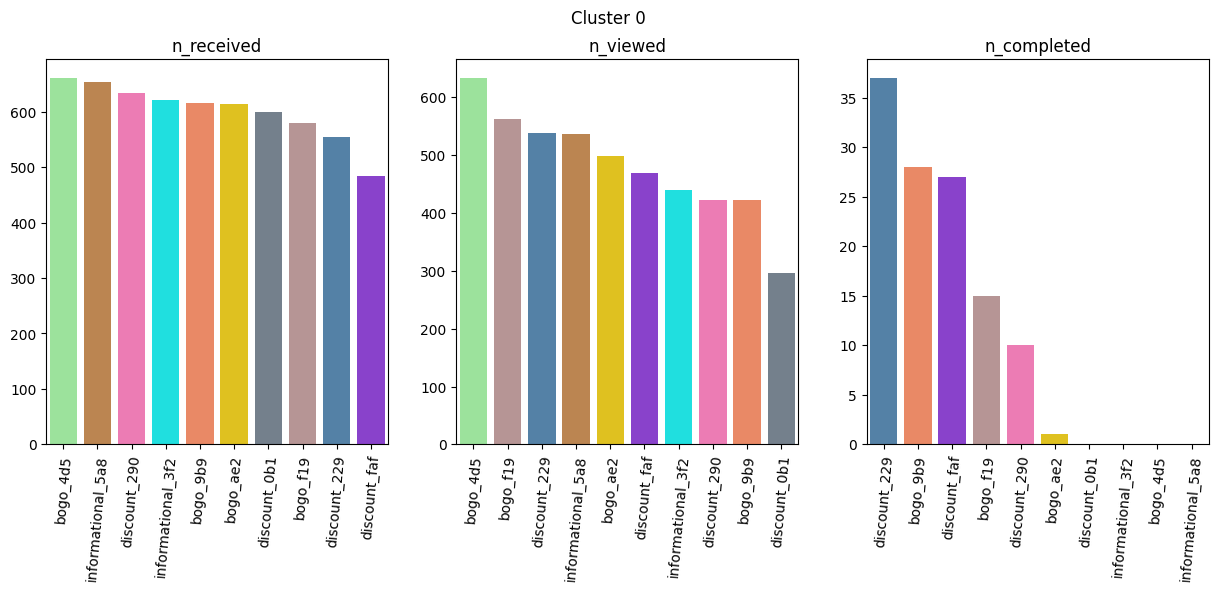

In [133]:
plot_ratios(offers_c1, "n_received", "n_viewed", "n_completed", 0)

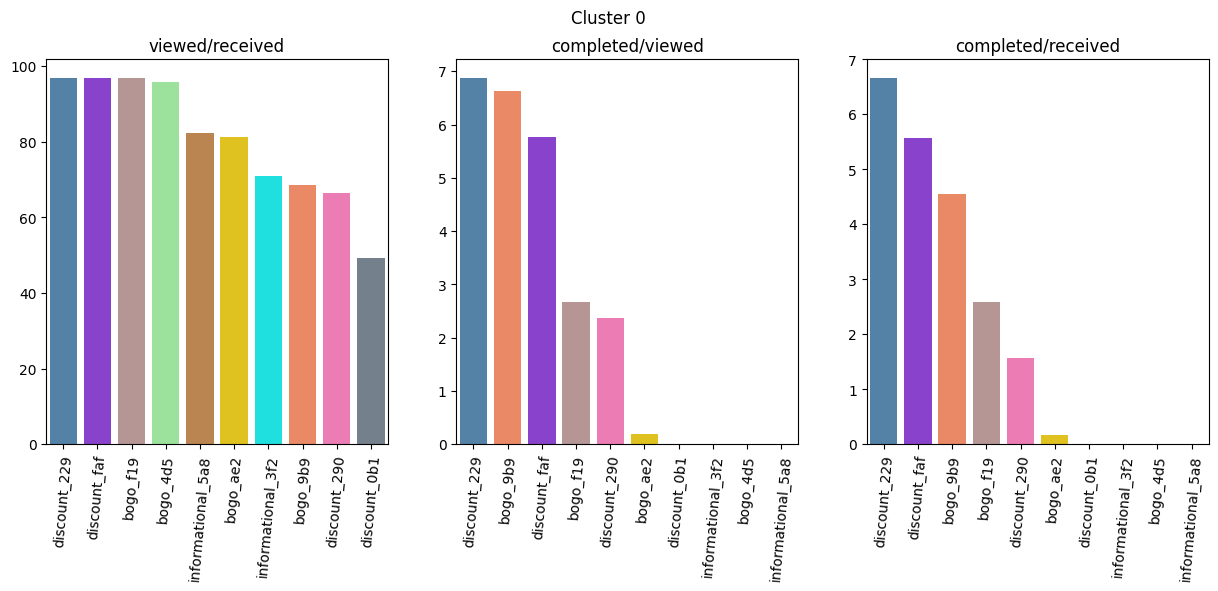

In [134]:
plot_ratios(offers_c1, "viewed/received", "completed/viewed", "completed/received", 0)

**For cluster 0 (Lost or Churned Customers):**

* Considering higher viewing of the offers received: ***discount_faf***, ***discount_229***, ***bogo_f19*** and ***bogo_4d5*** are the best options to send to this group
* ***discount_229***, ***bogo_9b9*** and ***discount_faf*** have the highest completion to viewing ratio. These are the same offers which are mostly viewed after being received as well.
* ***discount_229***, ***bogo_9b9*** and ***discount_faf*** have the best completion ratio after being received.
* **Overall Recommendation**: Do not focus on sending offers to this group as the conversion is very low. However, if offers must be sent, for a higher return focus on this three offers in this group - ***discount_faf***, ***discount_229*** and ***bogo_9b9***. 

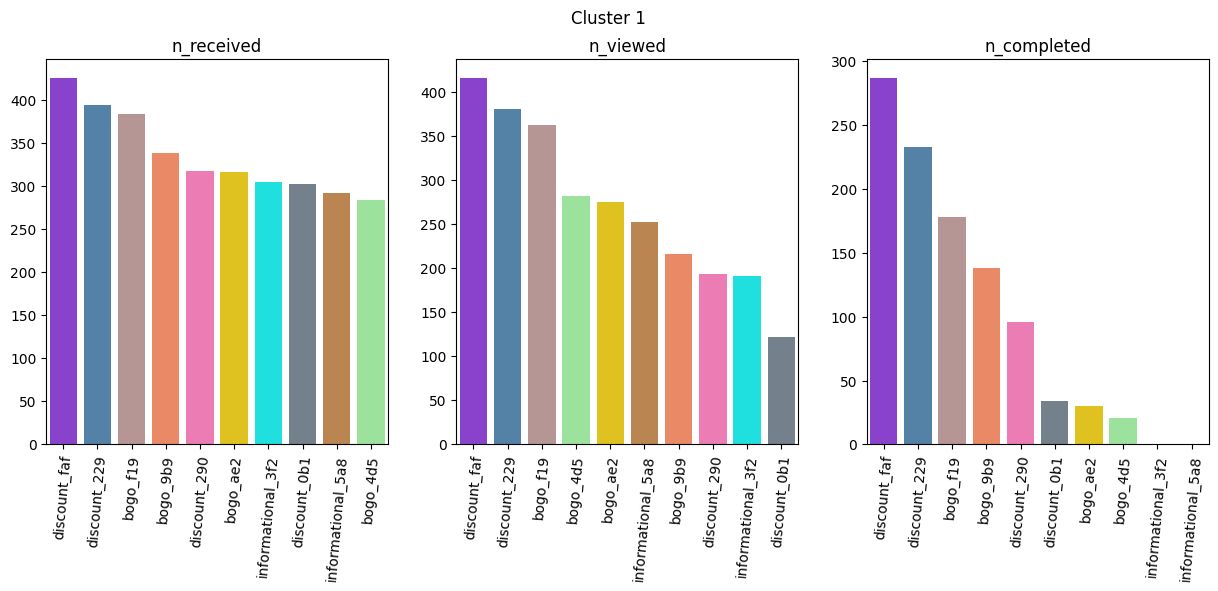

In [135]:
plot_ratios(offers_c2, "n_received", "n_viewed", "n_completed", 1)

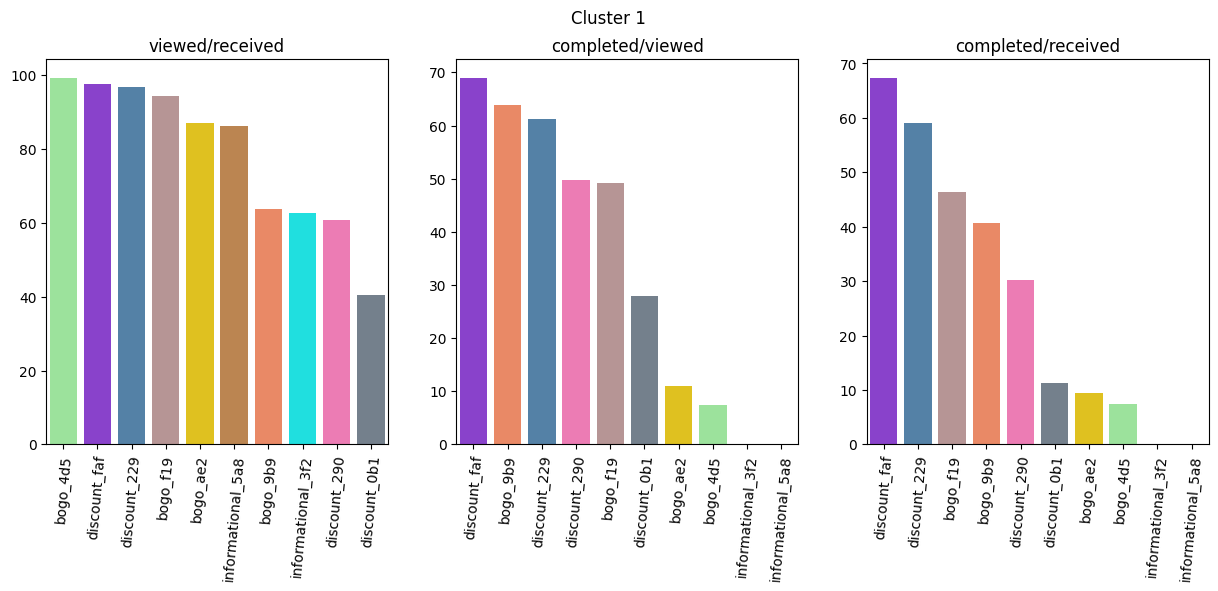

In [136]:
plot_ratios(offers_c2, "viewed/received", "completed/viewed", "completed/received", 1)

**For cluster 1 (Loyal Customers):**

* Considering higher viewing of the offers received: ***discount_faf***, ***discount_229***, ***bogo_f19***, ***bogo_ae2***, ***informational_5a8*** and ***bogo_4d5*** are the best options to send to this group
* ***discount_229***, ***bogo_9b9*** and ***discount_faf*** have the highest completion to viewing ratio. These are the same offers which are mostly viewed after being received as well.
* ***discount_faf***, ***bogo_9b9*** and ***discount_229*** have the best completion ratio after being received.
* **Overall Recommendation**: Sending offers ***discount_faf*** and ***discount_229*** to this group as the conversion is above 50%. 